# Auditory Classification of Syllabic Structures (ACSS)

Classifying diphones using Recurrent Neural Networks

## Setup

In [10]:
include("../src/Audios.jl")
include("../src/Model.jl")

using ..Audios, ..Model
using Flux, Plots, Random, StatsBase
using ProgressMeter
Plots.PythonPlotBackend()
Random.seed!(1234)

TaskLocalRNG()

## Data preparation

### Import audios

Audios are located in the `sounds/` folder in WAV format. Each file corresponds to a diphone, as spoken by one of the speakers available in the Apple Text-to-Speech software. These diphones were created by [Magnuson et al. (2020)](https://onlinelibrary.wiley.com/doi/full/10.1111/cogs.12823) for their EARSHOT model, and are openly available on the [GitHub repository](https://github.com/maglab-uconn/EARSHOT), following this [link](https://drive.google.com/file/d/1pujVHSPtwXWZiQeutFJwxdsz1mz0Lddi/view). File names are in the form `X_Y_Z.WAV`, where:

- `X` indicates the structure of the diphone (`CV` for consonant-vowel dipnes, `VC` for vowel-consonant diphones).
- `Y` indicates the orthographic form of the diphone in English, which was used to feed the Text-to-Speech software
- `Z` indicates the name of speaker used to generate the diphone.

In total, 7,190 audios are available, which correspond to 719 unique diphones, each generated by 10 different speakers (five female, five male).

In [2]:
# list WAV files
audio_path = "../sounds/raw/"
wav_files = readdir(audio_path, join = true)[contains.(lowercase.(readdir(audio_path)), ".wav")]
wav_names = basename.(wav_files)
N = length(wav_names)

# unique diphones
unique_diphones = unique(getindex.(split.(wav_names, "_"), 2));
unique_speakers = unique(getindex.(split.(wav_names, "_"), 3));

Divide the audios into training audios (`X_train`) and test audios (`X_test`). A proportion of `prop_train` of the audios will be assigned to the trining dataset, the rest to the test dataset. All audios corresponding to each diphone (as generated by different speakers) will either belong to the train *or* the test dataset.

In [3]:
prop_train = 0.10
indices = 1:length(unique_diphones)

n_train = convert(Int32, floor(length(indices) * prop_train))
train_diphones = sample(unique_diphones, n_train, replace = false)
test_diphones = unique_diphones[findall(i -> i ∉ train_diphones, unique_diphones)]

diphones = getindex.(split.(wav_names, "_"), 2)
train_idx = shuffle(findall(i -> i ∈ train_diphones, diphones))
test_idx = shuffle(findall(i -> i ∈ test_diphones, diphones))

6480-element Vector{Int64}:
  747
 2873
 4215
 1220
 2926
 2645
 4845
 2355
  160
 6793
    ⋮
 6327
 1565
 4858
 6703
 3669
    5
  991
 1705
 2621

#### Extract features and pair with their labels

In [4]:
prop_train = 0.85
indices = 1:length(unique_diphones)
n_train = convert(Int32, floor(length(indices) * prop_train))
train_diphones = sample(unique_diphones, n_train, replace = false)
test_diphones = unique_diphones[findall(i -> i ∉ train_diphones, unique_diphones)]

diphones = getindex.(split.(wav_names, "_"), 2)
train_idx = findall(i -> i ∈ train_diphones, diphones)
test_idx = findall(i -> i ∈ test_diphones, diphones)

println("Training dataset ($(round(prop_train, sigdigits = 2))): $(length(train_diphones)) diphones, $(length(train_idx)) audios")
println("Test dataset ($(round(1-prop_train, sigdigits = 2))): $(length(test_diphones)) diphones, $(length(test_idx)) audios")

Training dataset (0.85): 611 diphones, 6110 audios
Test dataset (0.15): 108 diphones, 1080 audios


#### Test dataset

In [5]:
X = make_features(wav_files)
y, labels = make_features(wav_files)

X_train = X[train_idx]
X_test = X[test_idx]

y_train, labels_train = y[train_idx], labels[train_idx]
y_test, labels_test = y[test_idx], labels[test_idx]

Importing audios... 100%|████████████████████████████████| Time: 0:00:19
Generating spectrograms... 100%|█████████████████████████| Time: 0:00:03
Padding spectograms to 53 time steps... 100%|████████████| Time: 0:00:01
Importing audios... 100%|████████████████████████████████| Time: 0:00:01
Generating spectrograms... 100%|█████████████████████████| Time: 0:00:02
Padding spectograms to 53 time steps... 100%|████████████| Time: 0:00:00


(Float32[0.7998239, 0.8711512, 0.96936595, 0.912018, 0.76610965, 0.8137583, 0.7174139, 0.84548116, 0.88074905, 0.816337  …  0.7476356, 0.8381865, 0.99017, 0.38410616, 0.68693364, 0.12500852, 0.11558184, 0.7963945, 0.39151368, 0.36526558], Float32[0.9436694, 1.0, 0.8323177, 0.84996146, 0.8693977, 0.9926272, 0.9845781, 0.7788386, 0.7758582, 0.7453762  …  0.37519702, 0.40488225, 0.30997288, 0.42289674, 0.12054427, 0.3879704, 0.24460615, 0.15532905, 0.19806492, 0.32562986])

## Model structure

In [7]:
args = Args(epochs = 100, η = 1e-3)

n_input = size(X_train[1], 1)
n_hidden = trunc(Int, n_input / 2)
n_output = length(unique(y_train)) - 1

6073

### Initial parameters and predictions

In [13]:

idxs = sample(shuffle(1:length(X)), 100)
X_a = X[idxs]
y_a = y[idxs]

model = Chain(
    GRU(n_input => n_hidden),
    Dense(n_hidden => n_output, sigmoid),
    sigmoid,
)

epochs = 20
opt_state = Flux.setup(ADAM(0.001), model)
N = length(X_test)

function my_loss(pred, y)
	return Flux.Losses.logitbinarycrossentropy(pred, y, agg = mean)
end


my_loss (generic function with 1 method)

## Training

In [15]:
loss_hist = []
acc_hist = []
ps_hist = []

for epoch ∈ 1:epochs

	loss_vec = []
	acc_vec = []
	local ∇
    local loss_val
	@showprogress for (x, y) in zip(X_train, y_train)

		loss_val, ∇ = Flux.withgradient(model) do m
			Flux.reset!(model)
			loss_val = my_loss(m(x), y)
			return loss_val
		end

		if !isfinite(loss_val)
			continue
		end
		push!(loss_vec, loss_val)
	end

	#push!(acc_vec, acc_val)

	Flux.update!(opt_state, model, ∇[1])
	push!(ps_hist, Flux.params(model))
	mean_loss = mean(loss_val)
	#mean_acc = mean(acc_val)

	push!(loss_hist, mean_loss)
	#push!(acc_hist, mean_acc)

	@info "Epoch $(epoch), loss = $(mean_loss)"
end

UndefVarError: UndefVarError: `loss_val` not defined

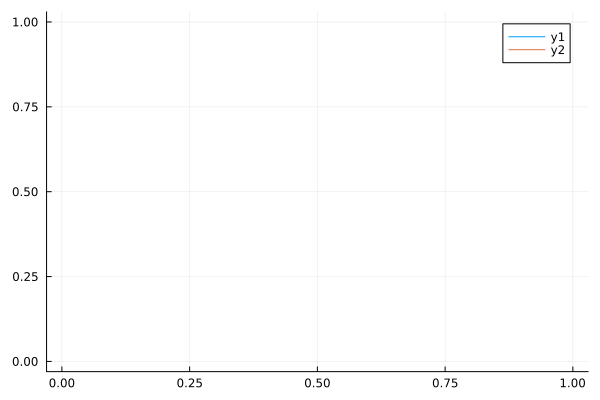

In [12]:
# plot training history
plot(loss_hist)

### Post training parameters and predictions


In [ ]:
p₁ = Flux.params(model)
probs₁, preds₁, acc₁ = make_predictions(model, X, y)
probs_test, preds_test, acc_test = make_predictions(model, X_test, y_test)